In [1]:
import numpy as np

In [13]:
import numpy as np
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook

def grayscale(img):
    '''
    Converts RGB image to Grayscale
    '''
    gray=np.zeros((img.shape[0],img.shape[1]))
    gray=img[:,:,0]*0.2989+img[:,:,1]*0.5870+img[:,:,2]*0.1140
    return gray

def plot_optical_flow(img,U,V,titleStr):
    '''
    Plots optical flow given U,V and one of the images
    '''
    
    # Change t if required, affects the number of arrows
    # t should be between 1 and min(U.shape[0],U.shape[1])
    t=10 
    
    # Subsample U and V to get visually pleasing output
    U1 = U[::t,::t]
    V1 = V[::t,::t]
    
    # Create meshgrid of subsampled coordinates
    r, c = img.shape[0],img.shape[1]
    cols,rows = np.meshgrid(np.linspace(0,c-1,c), np.linspace(0,r-1,r))
    cols = cols[::t,::t]
    rows = rows[::t,::t]
    
    # Plot optical flow
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.quiver(cols,rows,U1,V1)
    plt.title(titleStr)
    plt.show()
    

images=[]
for i in range(1,5):
    images.append(plt.imread('optical_flow_images/im'+str(i)+'.png')[:,:288,:])
# each image after converting to gray scale is of size -> 400x288

In [ ]:
# you can use interpolate from scipy
# You can implement 'upsample_flow' and 'OpticalFlowRefine' 
# as 2 building blocks in order to complete this.
from scipy.signal import convolve
from scipy import interpolate
def gradient(im1,im2):
    """ ==========
    Compute gradient of the image
    ========== """
    x_dir = np.array([-1/2, 0, 1/2]).reshape((1,3))
    y_dir = np.array([-1/2, 0, 1/2]).reshape((3,1))
    dIx = convolve(im1,x_dir,mode="same")
    dIy = convolve(im1,y_dir,mode="same")
    dIt = im2-im1
    return dIx,dIy,dIt

def upsample_flow(u_prev, v_prev):
    ''' You may implement this method to upsample optical flow from
    previous level
    u_prev, v_prev -> optical flow from prev level
    u, v -> upsampled optical flow to the current level
    '''
    f_u = interpolate.interp2d(np.arange(u_prev.shape[1]),np.arange(u_prev.shape[0]),u_prev)
    f_v = interpolate.interp2d(np.arange(v_prev.shape[1]),np.arange(v_prev.shape[0]),v_prev)
    
    u = f_u(np.linspace(0,u_prev.shape[1],u_prev.shape[1]*2),np.linspace(0,u_prev.shape[0],u_prev.shape[0]*2))
    v = f_v(np.linspace(0,v_prev.shape[1],v_prev.shape[1]*2),np.linspace(0,v_prev.shape[0],v_prev.shape[0]*2))
    return u, v

def downsample(img):
    kernel = np.array([[1,4,6,4,1],
                     [4,16,24,16,4],
                     [6,24,36,24,6],
                     [4,16,24,16,4],
                     [1,4,6,4,1]])/256
    downsample_img = convolve(img,kernel,mode='same')
    return downsample_img[::2,::2]

def pyramid(img,n):
    pyramids = [img]
    for _ in range(n):
        img = downsample(img)
        pyramids.append(img)
    return pyramids

def OpticalFlowRefine(im1,im2,window, u_prev=None, v_prev=None):
    '''
    Inputs: the two images at current level and window size
    u_prev, v_prev - previous levels optical flow
    Return u,v - optical flow at current level
    '''
    # upsample flow from previous level
    assert im1.shape==u_prev.shape
    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)
    row,col = im1.shape
    w = window//2
    dIx,dIy,_ = gradient(im1,im2)
    for i in range(w,row-w):
        for j in range(w,col-w):            
            row_i = int(max(0,min(i-v_prev[i,j],row-w-1))) 
            col_j = int(max(0,min(j-u_prev[i,j],col-w-1))) 
            Ix = dIx[i-w:i+w+1,j-w:j+w+1].flatten()
            Iy = dIy[i-w:i+w+1,j-w:j+w+1].flatten()
#             It = (im2[row_i-w:row_i+w+1,col_j-w:col_j+w+1]-im1[i-w:i+w+1,j-w:j+w+1]).flatten()
            It = (im1[i-w:i+w+1,j-w:j+w+1]-im2[row_i-w:row_i+w+1,col_j-w:col_j+w+1]).flatten()
            A = np.vstack((Ix, Iy)).T
            M = A.T@A
            b = A.T@-It.reshape(-1,1)
            U = np.linalg.solve(M,b)
            u[i,j] = U[0]
            v[i,j] = U[1]
    return u, v
def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    # call OpticalFlowRefine iteratively
    i = numLevels
    
    pyramids_im1 = pyramid(im1,numLevels)
    pyramids_im2 = pyramid(im2,numLevels)
    u_prev = None
    v_prev = None
    u_star,v_star = np.zeros(pyramids_im1[numLevels-1].shape),np.zeros(pyramids_im1[numLevels-1].shape)
    
    while i > 0:
        if u_prev is not None:
            u_star,v_star = upsample_flow(u_prev,v_prev)
            u_star,v_star = u_star*2,v_star*2
        u_prime,v_prime = OpticalFlowRefine(pyramids_im1[i-1],pyramids_im2[i-1],window,u_star,v_star)
        u_prev,v_prev = u_star+u_prime,v_star+v_prime
        i -= 1
    return u_prev, -v_prev

In [25]:
from scipy.signal import convolve


In [15]:
images[0].shape

(400, 288, 4)

In [17]:
im1 = grayscale(images[0])

In [18]:
im1.shape

(400, 288)

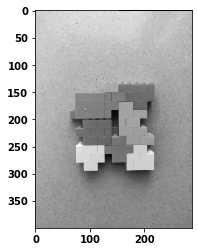

In [20]:
plt.imshow(im1,cmap='gray')
plt.show()

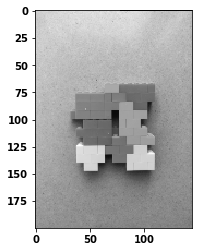

In [21]:
plt.imshow(im1[::2,::2],cmap='gray')
plt.show()

In [22]:
    kernel = np.array([[1,4,6,4,1],
                     [4,16,24,16,4],
                     [6,24,36,24,6],
                     [4,16,24,16,4],
                     [1,4,6,4,1]])/256

In [29]:
def downsample(img,n):
    kernel = np.array([[1,4,6,4,1],
                     [4,16,24,16,4],
                     [6,24,36,24,6],
                     [4,16,24,16,4],
                     [1,4,6,4,1]])/256
    downsample_img = convolve(img,kernel,mode='same')
    pyramids = []
    for i in range(n):
        pyramids.append(downsample_img[::2*(i+1),::2*(i+1)] )
    return pyramids

In [33]:
plt.imshow(downsample(im1,3)[3],cmap='gray')
plt.show()

IndexError: list index out of range

In [23]:
print(kernel)

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


In [74]:
a = np.arange(9).reshape(3,3)
b = np.arange(9).reshape(3,3)+2

In [42]:
Ix = a.flatten()

In [43]:
Iy = b.flatten()

In [44]:
A = np.vstack((Ix, Iy)).T

In [47]:
A.T@A

array([[204, 276],
       [276, 384]])

In [52]:
np.linalg.solve(A.T@A,A.T@Ix)

array([ 1.00000000e+00, -1.70234197e-15])

In [53]:
np.array(range(2))

array([0, 1])

In [48]:
A.shape

(9, 2)

In [46]:
np.matmul(A.T, A)

array([[204, 276],
       [276, 384]])

In [5]:
5//2

2

In [6]:
a[0]

array([0, 1, 2])

In [9]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [12]:
a/np.linalg.norm(a,axis=0)

array([[0.        , 0.09667365, 0.16903085, 0.22423053],
       [0.4472136 , 0.48336824, 0.50709255, 0.52320456],
       [0.89442719, 0.87006284, 0.84515425, 0.8221786 ]])

In [56]:
a

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [65]:
from scipy import interpolate

f = interpolate.interp2d(np.arange(a.shape[1]),np.arange(a.shape[0]),a)

In [66]:
f(np.linspace(0,a.shape[1],a.shape[1]*2),np.linspace(0,a.shape[0],a.shape[0]*2))

array([[0.04822736, 0.29160331, 0.51112896, 0.65910374, 0.78561943,
        0.89067604, 0.91694019, 0.91694019],
       [0.47254249, 0.37472137, 0.3632137 , 0.61064637, 0.71925657,
        0.6890443 , 0.68149124, 0.68149124],
       [0.79360838, 0.50467231, 0.33556488, 0.52594336, 0.57099749,
        0.47072728, 0.44565972, 0.44565972],
       [0.90817582, 0.72828901, 0.54844894, 0.36874907, 0.25894598,
        0.21903967, 0.20906309, 0.20906309],
       [0.94636497, 0.80282792, 0.6194103 , 0.31635097, 0.15492881,
        0.1351438 , 0.13019755, 0.13019755],
       [0.94636497, 0.80282792, 0.6194103 , 0.31635097, 0.15492881,
        0.1351438 , 0.13019755, 0.13019755]])

In [59]:
np.linspace(0, 2, 4)

array([0.        , 0.66666667, 1.33333333, 2.        ])

In [63]:
a = np.random.random((3,4))

In [64]:
a

array([[0.04822736, 0.47413527, 0.73309113, 0.91694019],
       [0.75541924, 0.18616904, 0.73521042, 0.52452527],
       [0.94636497, 0.69517513, 0.16482131, 0.13019755]])

In [68]:
f(1,2)

array([0.69517513])

In [69]:
def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
    '''
    Implement the multi-resolution Lucas kanade algorithm
    Inputs: the two images, window size and number of levels
    if numLevels = 1, then compute optical flow at only the given image level.
    Returns: u, v - the optical flow
    '''
    # call OpticalFlowRefine iteratively
    i = numLevels
    
    pyramids_im1 = pyramid(im1,numLevels)
    pyramids_im2 = pyramid(im2,numLevels)
    u_prev = None
    v_prev = None
    
    while i > 0:
        u_prime,v_prime = OpticalFlowRefine(pyramids_im1[i-1],pyramids_im2[i-1],window,u_prev,v_prev)
        if u_prev is None:
            u,v = u_prime,v_prime
        else:
            u,v = u_prime+u_prev,v_prime+v_prev
        u_prev,v_prev = upsample_flow(u,v)
        u_prev,u_prev = u_prev*2,u_prev*2
        i -= 1
    return u, v

TypeError: unsupported operand type(s) for +: 'int' and 'NoneType'

In [ ]:
# def LucasKanadeMultiScale(im1,im2,window, numLevels=2):
#     '''
#     Implement the multi-resolution Lucas kanade algorithm
#     Inputs: the two images, window size and number of levels
#     if numLevels = 1, then compute optical flow at only the given image level.
#     Returns: u, v - the optical flow
#     '''
#     # call OpticalFlowRefine iteratively
#     i = numLevels
    
#     pyramids_im1 = pyramid(im1,numLevels)
#     pyramids_im2 = pyramid(im2,numLevels)
#     u_prev = None
#     v_prev = None
    
#     while i > 0:
#         if u_prev is not None:
#             u_star,v_star = upsample_flow(u_prev,v_prev)
#             u_star,v_star = u_prev*2,v_prev*2
#         u_prime,v_prime = OpticalFlowRefine(pyramids_im1[i-1],pyramids_im2[i-1],window,u_prev,v_prev)
#         u,v = u_prime+u_prev,v_prime+v_prev
#         i -= 1
#     return u, v


In [ ]:
#                 It = (im1[row_i-w:row_i+w+1,col_j-w:col_j+w+1]-im2[i-w:i+w+1,j-w:j+w+1]).flatten()

def findshift(im1,im2,window):
    u = np.zeros(im1.shape)
    v = np.zeros(im1.shape)
    row,col = im1.shape
    w = window//2
    dIx,dIy,dIt = gradient(im1,im2)
    for i in range(w,row-w):
        for j in range(w,col-w):
            Ix = dIx[i-w:i+w+1,j-w:j+w+1].flatten()
            Iy = dIy[i-w:i+w+1,j-w:j+w+1].flatten()
            It = dIt[i-w:i+w+1,j-w:j+w+1].flatten()
            A = np.vstack((Ix,Iy)).T
            M = A.T@A
            b = A.T@-It.reshape(-1,1)
            U = np.linalg.solve(M,b)
            u[i,j] = U[0]
            v[i,j] = U[1]
    return u,v

In [ ]:
    while i > 0:
        u_prime,v_prime = OpticalFlowRefine(pyramids_im1[i-1],pyramids_im2[i-1],window,u_prev,v_prev)
        if u_prev is None:
            u,v = u_prime,v_prime
        else:
            u,v = u_prime+u_prev,v_prime+v_prev
        u_prev,v_prev = upsample_flow(u,v)
        u_prev,v_prev = u_prev*2,v_prev*2
        i -= 1
    return u, v

In [72]:
np.vstack((np.arange(9),np.arange(9)+2)).T

array([[ 0,  2],
       [ 1,  3],
       [ 2,  4],
       [ 3,  5],
       [ 4,  6],
       [ 5,  7],
       [ 6,  8],
       [ 7,  9],
       [ 8, 10]])

In [75]:
a@b

array([[ 21,  24,  27],
       [ 66,  78,  90],
       [111, 132, 153]])

In [76]:
np.dot(a,b)

array([[ 21,  24,  27],
       [ 66,  78,  90],
       [111, 132, 153]])